LASSO RIDGE, XGBOOST
REPORT ERROR WITH Cross Validation (K- FOLD 5 OR 10 PIECES)

## Introduction

##### $\rightarrow$ The purpose of this notebook is to analyze the prepared homelessness data and perform regressions and model fitting to find out if we can predit homelessness rates based on a number of predictors relating to housing, climate and geographic factors amoung others

## Import libraries

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries
from sklearn.preprocessing import RobustScaler
# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

#Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from scipy.stats import uniform, randint
import xgboost as xgb

from sklearn import tree

#Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Model metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, mean_absolute_error

#Missing data
import missingno as msno

# plot tree model
import graphviz

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [133]:
df = pd.read_csv('https://github.com/hopecrosier/Homelessness/raw/main/Data/df.csv')

In [134]:
federal_aid_df = pd.read_csv('https://github.com/hopecrosier/Homelessness/raw/main/Data/federal-aid-by-state-2023.csv')

##### $\rightarrow$ Review the contents of the data set.

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   total_homeless                              374 non-null    float64
 3   total_sheltered                             374 non-null    float64
 4   total_unsheltered                           374 non-null    float64
 5   total_population                            374 non-null    int64  
 6   house_price_index_2009                      374 non-null    float64
 7   log_median_rent                             374 non-null    float64
 8   utility_costs                               374 non-null    float64
 9   percentage_owners_cost_burden_2016          374 non-null    float64
 10  percentage_ren

In [136]:
federal_aid_df = federal_aid_df.drop(columns = ['federalFunding', 'benefitsRecipients', 'HouseholdIncome'])

Add a state column since our additional step data is seperated by individual state and there can be multiple CoC's for one state

In [137]:
df['state'] = [df['coc_number'].str.split('-')[n][0] for n in range(374)]

In [138]:
df.head(10)

,year,coc_number,total_homeless,total_sheltered,total_unsheltered,total_population,house_price_index_2009,log_median_rent,utility_costs,percentage_owners_cost_burden_2016,...,rate_sheltered,rate_unsheltered,percent_black,percent_latino_hispanic,percent_asian,percent_pacific_islander,percent_population_65_plus,percent_population_0_19,percent_female_population,state
0,2017,AK-500,1128.0,973.0,155.0,297376,11.743647,2.438863,8.500000,15.334315,...,32.719520,5.212257,0.053811,0.089967,0.093952,0.024387,0.099140,0.269161,0.489629,AK
1,2017,AK-501,717.0,578.0,139.0,444146,9.042710,2.249699,14.607715,13.311670,...,13.013739,3.129602,0.019530,0.055727,0.040104,0.004593,0.109905,0.278562,0.467752,AK
2,2017,AL-500,1092.0,875.0,217.0,958302,-0.852477,1.862248,19.492331,12.188416,...,9.130733,2.264422,0.331147,0.040843,0.016632,0.000311,0.149058,0.256410,0.521677,AL
3,2017,AL-501,606.0,341.0,265.0,622361,-8.507004,1.858394,18.899839,12.539132,...,5.479135,4.257979,0.266807,0.033816,0.016889,0.000382,0.167126,0.254735,0.519669,AL
4,2017,AL-502,155.0,133.0,22.0,265264,0.751167,1.362010,18.803186,10.374694,...,5.013873,0.829362,0.090348,0.042056,0.004901,0.000471,0.190708,0.236545,0.513937,AL
5,2017,AL-503,436.0,337.0,99.0,568051,-3.955391,1.726037,16.025249,9.751287,...,5.932566,1.742801,0.200109,0.056808,0.020382,0.000856,0.148768,0.250120,0.508777,AL
6,2017,AL-504,377.0,314.0,63.0,383916,-9.366414,1.815957,20.544085,13.145372,...,8.178872,1.640984,0.450036,0.032507,0.020445,0.000511,0.144318,0.258989,0.520452,AL
7,2017,AL-505,163.0,103.0,60.0,314688,-6.694551,1.440278,18.732853,12.391777,...,3.273083,1.906650,0.132731,0.059821,0.006730,0.000591,0.176740,0.247035,0.513680,AL
8,2017,AL-506,200.0,137.0,63.0,206282,-0.422569,1.805005,17.600000,12.762038,...,6.641394,3.054072,0.314855,0.036305,0.015081,0.000373,0.125072,0.260236,0.518067,AL
9,2017,AL-507,764.0,416.0,348.0,1483504,-5.543242,1.451315,19.256779,11.938075,...,2.804172,2.345798,0.243594,0.040342,0.009577,0.000448,0.172763,0.249057,0.511821,AL


In [139]:
df = df.merge(federal_aid_df, on='state', how='left')

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 58 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   total_homeless                              374 non-null    float64
 3   total_sheltered                             374 non-null    float64
 4   total_unsheltered                           374 non-null    float64
 5   total_population                            374 non-null    int64  
 6   house_price_index_2009                      374 non-null    float64
 7   log_median_rent                             374 non-null    float64
 8   utility_costs                               374 non-null    float64
 9   percentage_owners_cost_burden_2016          374 non-null    float64
 10  percentage_ren

Now we have our additional step data loaded into our main dataframe

In [141]:
df = df.loc[df['totalFederalFunding'].notna()]

In [142]:
df = df.rename(columns = {'totalFederalFunding': 'total_federal_funding'})

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 0 to 373
Data columns (total 58 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        373 non-null    int64  
 1   coc_number                                  373 non-null    object 
 2   total_homeless                              373 non-null    float64
 3   total_sheltered                             373 non-null    float64
 4   total_unsheltered                           373 non-null    float64
 5   total_population                            373 non-null    int64  
 6   house_price_index_2009                      373 non-null    float64
 7   log_median_rent                             373 non-null    float64
 8   utility_costs                               373 non-null    float64
 9   percentage_owners_cost_burden_2016          373 non-null    float64
 10  percentage_ren

I went through and got rid of the one null value, and renamed the columns to match our existing column format/style

---

## State your questions

The overall problem is to determine whether and how housing market factors are related to homelessness. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.

1. How well can we fit a model to predict homelessness rate? 
2. What predictors are significant in predicting homelessness rate?
3. Does financial aid given to each state have a significant impact on homelessness rate?


#Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

This file should clearly produce the graphs, tables, models, etc that appear in the communication assignment.

---
# Train Test Split

We want to perform a train test split on our data now

In [144]:
variable_remove = ['total_sheltered', 'total_unsheltered', 'total_black', 'total_latino_hispanic', 'total_asian', 
                   'total_pacific_islander', 'total_population_0_19', 'total_population_65_plus', 'total_female_population', 
                   'year', 'rate_unsheltered', 'rate_sheltered']

In [145]:
df = df.drop(columns = variable_remove)

In [146]:
X = df[df.columns.difference(['coc_number', 'total_homeless', 'total_population', 'rate_homeless', 'state'])]
y = df['rate_homeless']

Now we fit a basic model of our predictors

In [147]:
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          rate_homeless   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     11.17
Date:                Wed, 24 May 2023   Prob (F-statistic):           3.50e-41
Time:                        21:36:27   Log-Likelihood:                -1374.0
No. Observations:                 373   AIC:                             2830.
Df Residuals:                     332   BIC:                             2991.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

This model gives us an R-squared value of 0.567, which tells us that this model is an okay fit to the data, but it could probaby be improved.

In [148]:
y_prediction = model.predict()

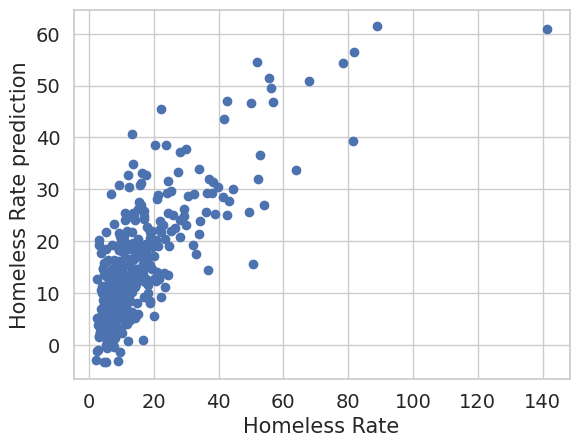

In [149]:
plt.plot(df['rate_homeless'], y_prediction, 'o')

# Add axis labels
plt.xlabel('Homeless Rate', fontsize=15)
plt.ylabel('Homeless Rate prediction', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

This is the graphical relationship between our models predictions and the actual homelessness rate of our data

Now we create the train test split

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

In [151]:
print(X_train.shape, X_test.shape)

(298, 41) (75, 41)


In [152]:
X_train.agg(['mean','std']).round(2)
X_train.describe()

,HUD_unit_occupancy_rate,average_Jan_temperature,average_summer_temperature,city_or_urban,gini_coefficient_2016,high_housing_density,house_price_index_2009,log_median_rent,median_housing_structure_age,medicare_reimbursements_per_enrollee,...,share_no_bachelors,share_overcrowded_units_2016,share_renters_2016,share_under_18_with_single_parent,share_veteran_status,suburban,total_Jan_precipitation,total_annual_precipitation,total_federal_funding,utility_costs
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,...,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,2.980000e+02,298.000000
mean,92.534308,39.188940,75.106823,0.275168,45.578363,0.268456,7.521351,2.026419,1975.242874,9.955626,...,68.809977,2.778446,34.953174,25.709364,9.904267,0.419463,4.481843,38.927787,1.480937e+11,14.778397
std,4.169938,12.082869,5.935651,0.447350,2.941556,0.443902,15.123423,0.311883,11.031296,1.203865,...,10.539657,2.059308,8.453904,6.824729,2.837496,0.494301,3.899460,14.006410,1.273463e+11,3.041659
min,73.000000,10.980627,59.553333,0.000000,37.560001,0.000000,-17.533745,1.440278,1939.000000,6.790910,...,23.686455,0.655098,18.754652,9.774630,2.820653,0.000000,0.210000,3.060000,1.768000e+09,5.900000
25%,90.299185,30.607500,71.359165,0.000000,43.755000,0.000000,-2.614267,1.805125,1967.658386,9.077180,...,62.916432,1.532690,28.818393,21.054680,8.080933,0.000000,2.432481,33.577628,6.440000e+10,12.900000
50%,93.000000,37.587610,75.191666,0.000000,45.471949,0.000000,3.744354,1.989422,1977.000000,9.816548,...,70.270004,2.049100,33.993050,24.535183,9.992773,0.000000,3.373393,38.419998,1.051000e+11,14.850000
75%,95.000000,46.557502,79.662607,1.000000,47.129789,1.000000,14.222462,2.217025,1983.685822,10.667173,...,76.798178,3.049372,40.735456,29.432372,11.278370,1.000000,4.753509,44.306774,2.206000e+11,17.165218
max,100.000000,73.500000,93.250000,1.000000,54.779999,1.000000,63.864007,2.874838,1998.000000,14.309140,...,86.394447,12.264590,69.224808,54.470425,22.270695,1.000000,25.321701,96.339996,4.361000e+11,22.600000


In [153]:
X_test.agg(['mean','std']).round(2)

,HUD_unit_occupancy_rate,average_Jan_temperature,average_summer_temperature,city_or_urban,gini_coefficient_2016,high_housing_density,house_price_index_2009,log_median_rent,median_housing_structure_age,medicare_reimbursements_per_enrollee,...,share_no_bachelors,share_overcrowded_units_2016,share_renters_2016,share_under_18_with_single_parent,share_veteran_status,suburban,total_Jan_precipitation,total_annual_precipitation,total_federal_funding,utility_costs
mean,92.00,38.73,75.32,0.28,45.21,0.19,4.04,1.99,1975.79,9.76,...,69.56,2.42,32.72,25.66,10.14,0.47,4.04,41.54,1.104797e+11,15.14
std,3.72,12.18,5.66,0.45,2.36,0.39,12.06,0.29,9.25,1.22,...,9.72,1.48,6.69,6.79,2.94,0.50,2.62,12.26,9.221057e+10,2.61


We want to use the Robust Scaler to fit our data.

In [154]:
scaler = RobustScaler().fit(X_train)

In [155]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [156]:
modelScaler = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

In [157]:
print(modelScaler.summary())

                            OLS Regression Results                            
Dep. Variable:          rate_homeless   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     8.961
Date:                Wed, 24 May 2023   Prob (F-statistic):           1.26e-30
Time:                        21:36:28   Log-Likelihood:                -1115.3
No. Observations:                 298   AIC:                             2315.
Df Residuals:                     256   BIC:                             2470.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9130      2.262      6.593      0.0

We've already improved our R-squared value to 0.580, but there might be an even better model out there.

In [158]:
variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(index = variables, data = {'p-value':modelScaler.pvalues.values.round(3), 'significant': model.pvalues.values < 0.05})

,p-value,significant
intercept,0.000,True
HUD_unit_occupancy_rate,0.133,False
average_Jan_temperature,0.409,False
average_summer_temperature,0.471,False
city_or_urban,0.947,False
gini_coefficient_2016,0.814,False
high_housing_density,0.368,False
house_price_index_2009,0.590,False
log_median_rent,0.099,True
median_housing_structure_age,0.020,True


This tells us what predictors are seemingly significant in our model and which ones are not.

In [159]:
MSE = mean_squared_error(y_test, modelScaler.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, modelScaler.predict(sm.add_constant(X_test)))

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 57.45  RMSE = 7.58  R-squared = 0.045


We can see here that using the Robust Scaler on the test data gives us an R squared value of 0.045 which is very low.

--- 
#Lasso

Now we want to find the parameters in the linear model by minimizing a penalized squared error, and we do this using the Lasso technique 

In [160]:
alphas = 10**np.linspace(-4,0,10)

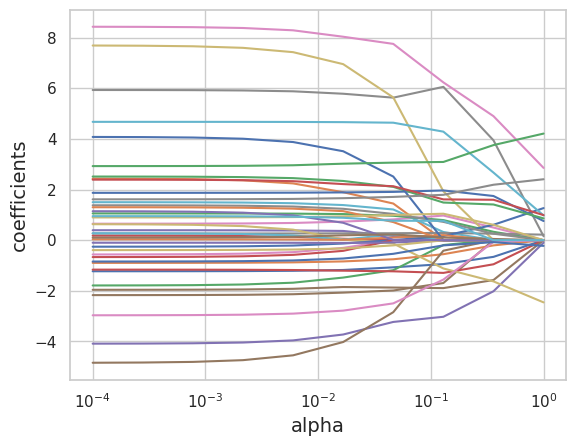

In [161]:
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

Cross Validation - 5 Fold

In [162]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)

In [163]:
lassocv.fit(X_train, y_train)
lassocv.alpha_

1.100490272170642

This is the best alpha that the lasso produced

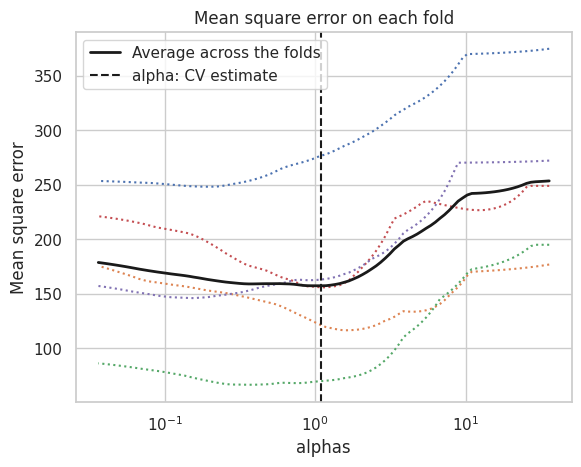

In [164]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

Now we want to fit the Lasso model on the training data with the best $\alpha$ and examine the coefficients.

In [165]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)

In [166]:
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients.round(2), index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,12.86
HUD_unit_occupancy_rate,-0.00
average_Jan_temperature,-0.00
average_summer_temperature,-0.00
city_or_urban,0.00
gini_coefficient_2016,0.00
high_housing_density,-0.00
house_price_index_2009,0.00
log_median_rent,0.00
median_housing_structure_age,-0.00


These estimated coefficients follow a similar pattern to the one we saw before on our basic model, where not all of them had a significance to the model.

Now we use the lasso model to predict the test data. We want to compute the MSE, RMSE, and $R^2$.

In [167]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 42.188  RMSE = 6.495  R-squared = 0.299


Our R-squared value has gone up, which means we are starting to get a better fit of the data!

We want to make a scatter plot of the measured homelessness rate vs. the predicted homelessness rate.

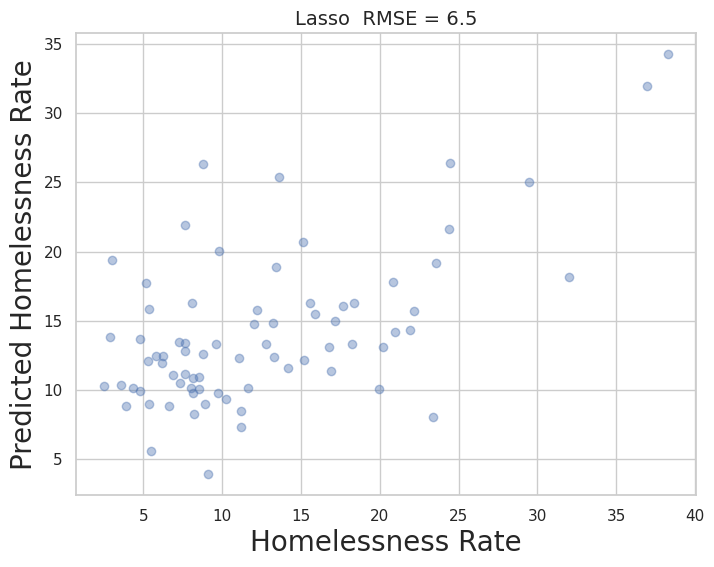

In [168]:
plt.figure(figsize=(8,6))

plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)

plt.xlabel('Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted Homelessness Rate',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14);

While the relationship here isn't super strong, there is a faint linear relationship between the actual and predicted rates.

---
#Ridge Regression

Now we want to find the parameters in the linear model by minimizing a penalized squared error using Ridge Regression.

In [169]:
alphas = 10**np.linspace(-3,5,20)

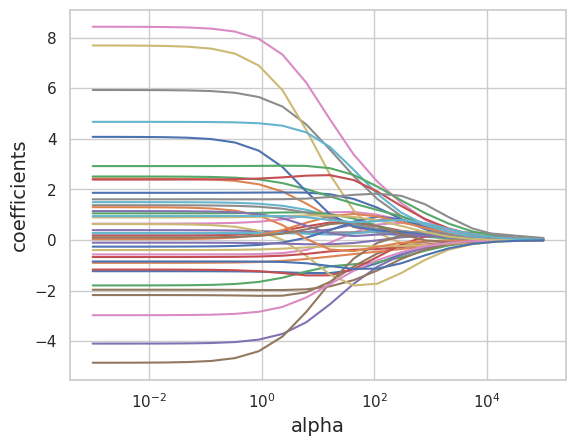

In [170]:
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

Now we want to use cross-validation to find the best alpha for Ridge regression.

In [171]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);

In [172]:
ridgecv.alpha_

112.88378916846884

This is the best alpha

Now we fit the ridge regression model on the training data with the best $\alpha$ and examine the coefficients.

In [173]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)

In [174]:
coefficients = ridge_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, ridge_reg.intercept_.round(3))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,13.091
HUD_unit_occupancy_rate,-0.911
average_Jan_temperature,0.298
average_summer_temperature,-0.876
city_or_urban,0.550
gini_coefficient_2016,0.787
high_housing_density,-0.525
house_price_index_2009,0.999
log_median_rent,1.620
median_housing_structure_age,0.287


This table above shows us the associated coefficient and therefore significance of each predictor in our model

Now we use the ridge regression model to predict the test data, we want to compute the MSE, RMSE and $R^2$.

In [175]:
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 44.752  RMSE = 6.69  R-squared = 0.256


We can see here that our R-squared value is now 0.256 which is an improvement from our Robust Scalar

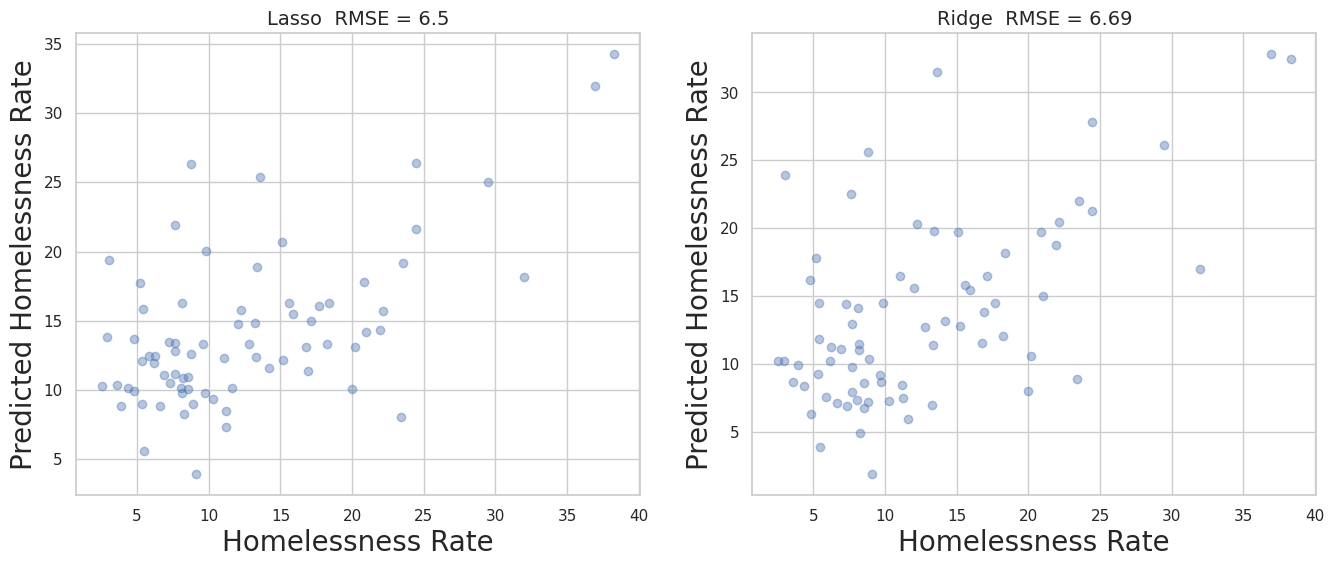

In [176]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted Homelessness Rate',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Homelessness Rate',fontsize = 20)
plt.ylabel('Predicted Homelessness Rate',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

plt.subplots_adjust(hspace = 0.5)

We can see here that the Lasso and Ridge Regression methods give us similar RSME and associated predicted homelessness rates

---
#XGBoost

Now we want to use XGBoost to model our data and get predictions

In [177]:
y_pred = modelScaler.predict(sm.add_constant(X_test))

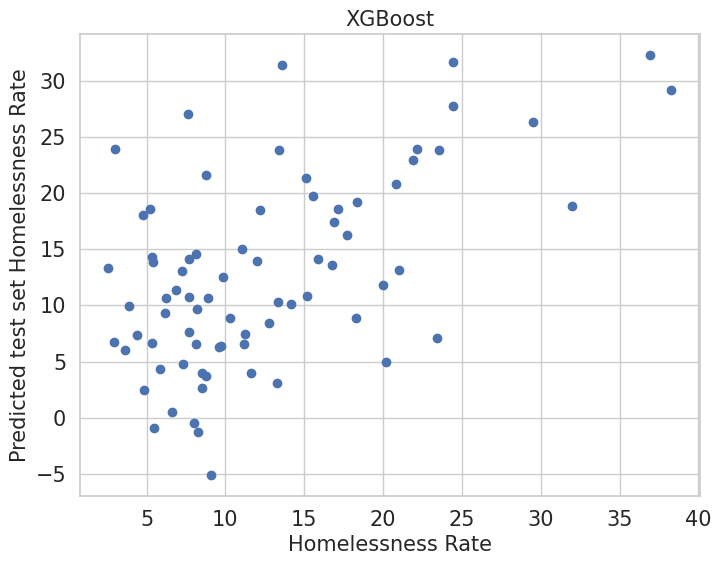

In [178]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred, 'o');

plt.xlabel('Homelessness Rate', fontsize = 15)
plt.ylabel('Predicted test set Homelessness Rate', fontsize = 15)
plt.title('XGBoost', fontsize = 15)


plt.tick_params(labelsize = 15)

This is a graph showing the relationship between the actual homelessness rate and the predicted homelessness rate using our scalar model

We want to see what the RMSE is

In [179]:
mean_squared_error(y_test, y_pred, squared = False).round(3)

7.58

And now the mean absolute error

In [180]:
mean_absolute_error(y_test, y_pred).round(3)

5.907

In [181]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff97e521d50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff97e520730>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff97e5214b0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff97e5217e0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [182]:
search.best_params_

{'colsample_bytree': 0.8187444940326486,
 'gamma': 0.30005144198861317,
 'learning_rate': 0.11830630490072584,
 'max_depth': 3,
 'n_estimators': 122,
 'subsample': 0.7939545828475287}

We want to make an XGBoost using the best parameters

In [183]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")

In [184]:
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8187444940326486, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.30005144198861317, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.11830630490072584, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=122, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Now we fit the model on the training data

In [185]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8187444940326486, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.30005144198861317, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.11830630490072584, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=122, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

And fit the test data

In [186]:
y_pred_xgb = model_xgb.predict(X_test)

Plot our predictions so we can see how well it fits

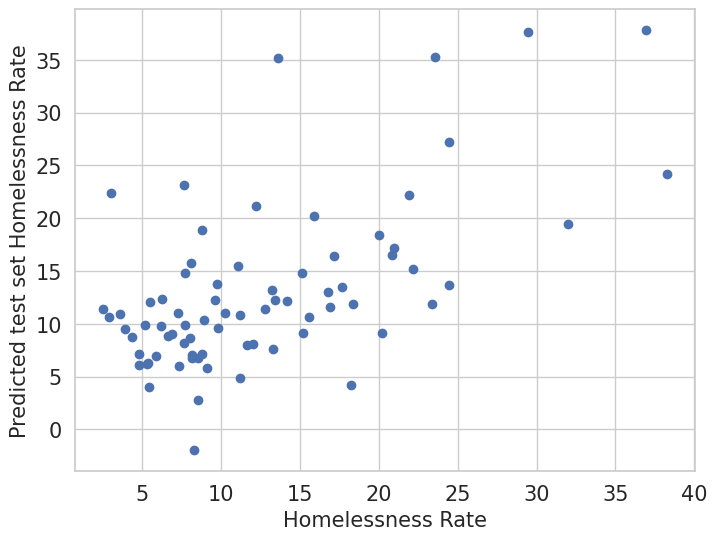

In [187]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('Homelessness Rate', fontsize = 15)
plt.ylabel('Predicted test set Homelessness Rate', fontsize = 15)

plt.tick_params(labelsize = 15)

Again we can see a somewhat linear relationship between our actual data and our predicted data using our test set

We want to look at the RSME and mean absolute error of our prediction/model 

In [188]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

6.819

In [189]:
mean_absolute_error(y_test, y_pred_xgb).round(3)

5.061

This tells us that we can predict the homelessness rate within around 2.5% accuracy for a CoC

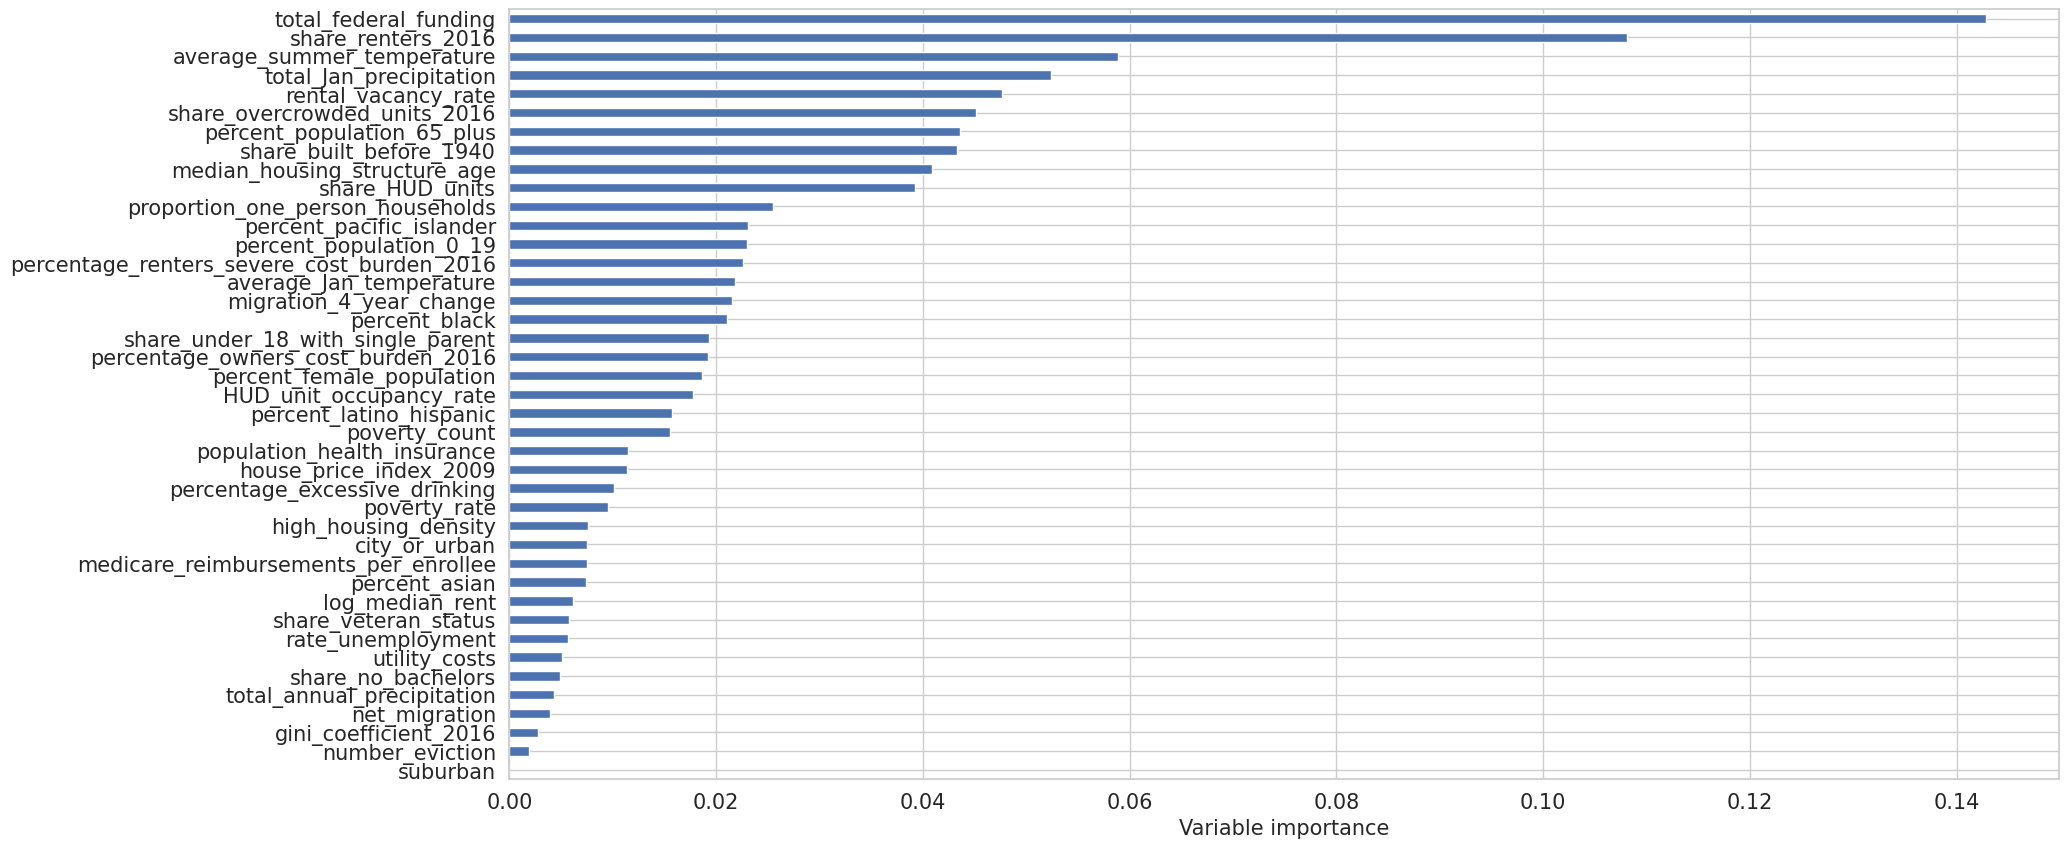

In [190]:
(pd.DataFrame(dict(cols = X.columns, imp=model_xgb.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (20,10)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 15);

Here we can see that predictors such as `total_federal_funding`, `rental_vacancy_rate` and `share_renters_2016` amoung others, are highly important in the model we've created.

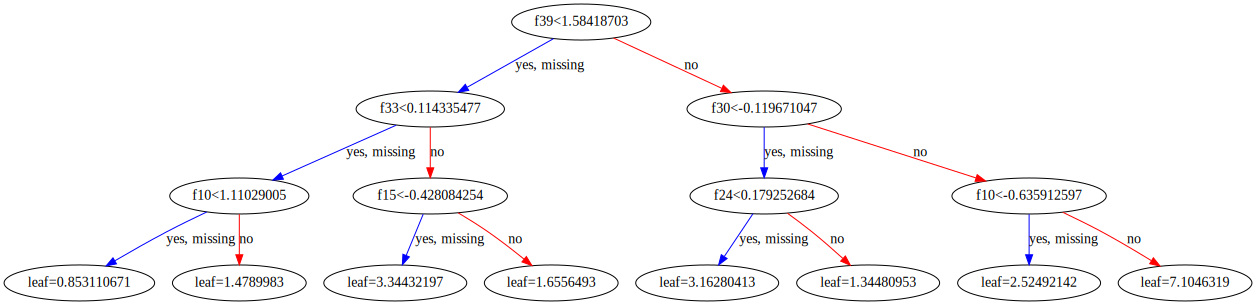

In [191]:
xgb.to_graphviz(model_xgb, num_trees=1)

---
#Cross Validation

In [192]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

In [193]:
# Initialize a list to record the RMSE
tree_rmse_kfold = []

# Create the model object
modelCross = tree.DecisionTreeRegressor()

# Create the k-folds object with the number of splits
kf = KFold(n_splits=10)

# Loop over all splits
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index,:]
    y_test = y.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(modelCross, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the best model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(X_train, y_train)

    # Predict
    y_prediction = tree_model.predict(X_test)

    tree_rmse_kfold.append(mean_squared_error(y_test, y_prediction, squared=False))

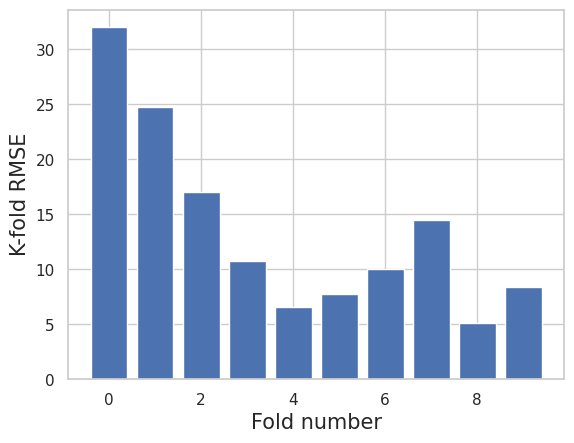

In [194]:
#plt.boxplot(tree_rmse);
plt.bar(np.arange(kf.get_n_splits()), tree_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);

This graph shows us the associated RSME with each different number of folds, and as we can see the RSME is fairly low around the 4 and 5 folds as well as the 8 fold. Since we did a 5-fold before, I feel good about the data that I produced from that analysis since we can see here that using 5 folds gives us one of the lowest RSME

In [195]:
pd.DataFrame(tree_rmse_kfold).describe()

,0
count,10.000000
mean,13.688168
std,8.697295
min,5.071798
25%,7.887517
50%,10.414948
75%,16.385769
max,32.003727


---
#Additional Step

As we can see in the graph above, the `total_federal_funding` predictor from our additional step data is the most important variable 

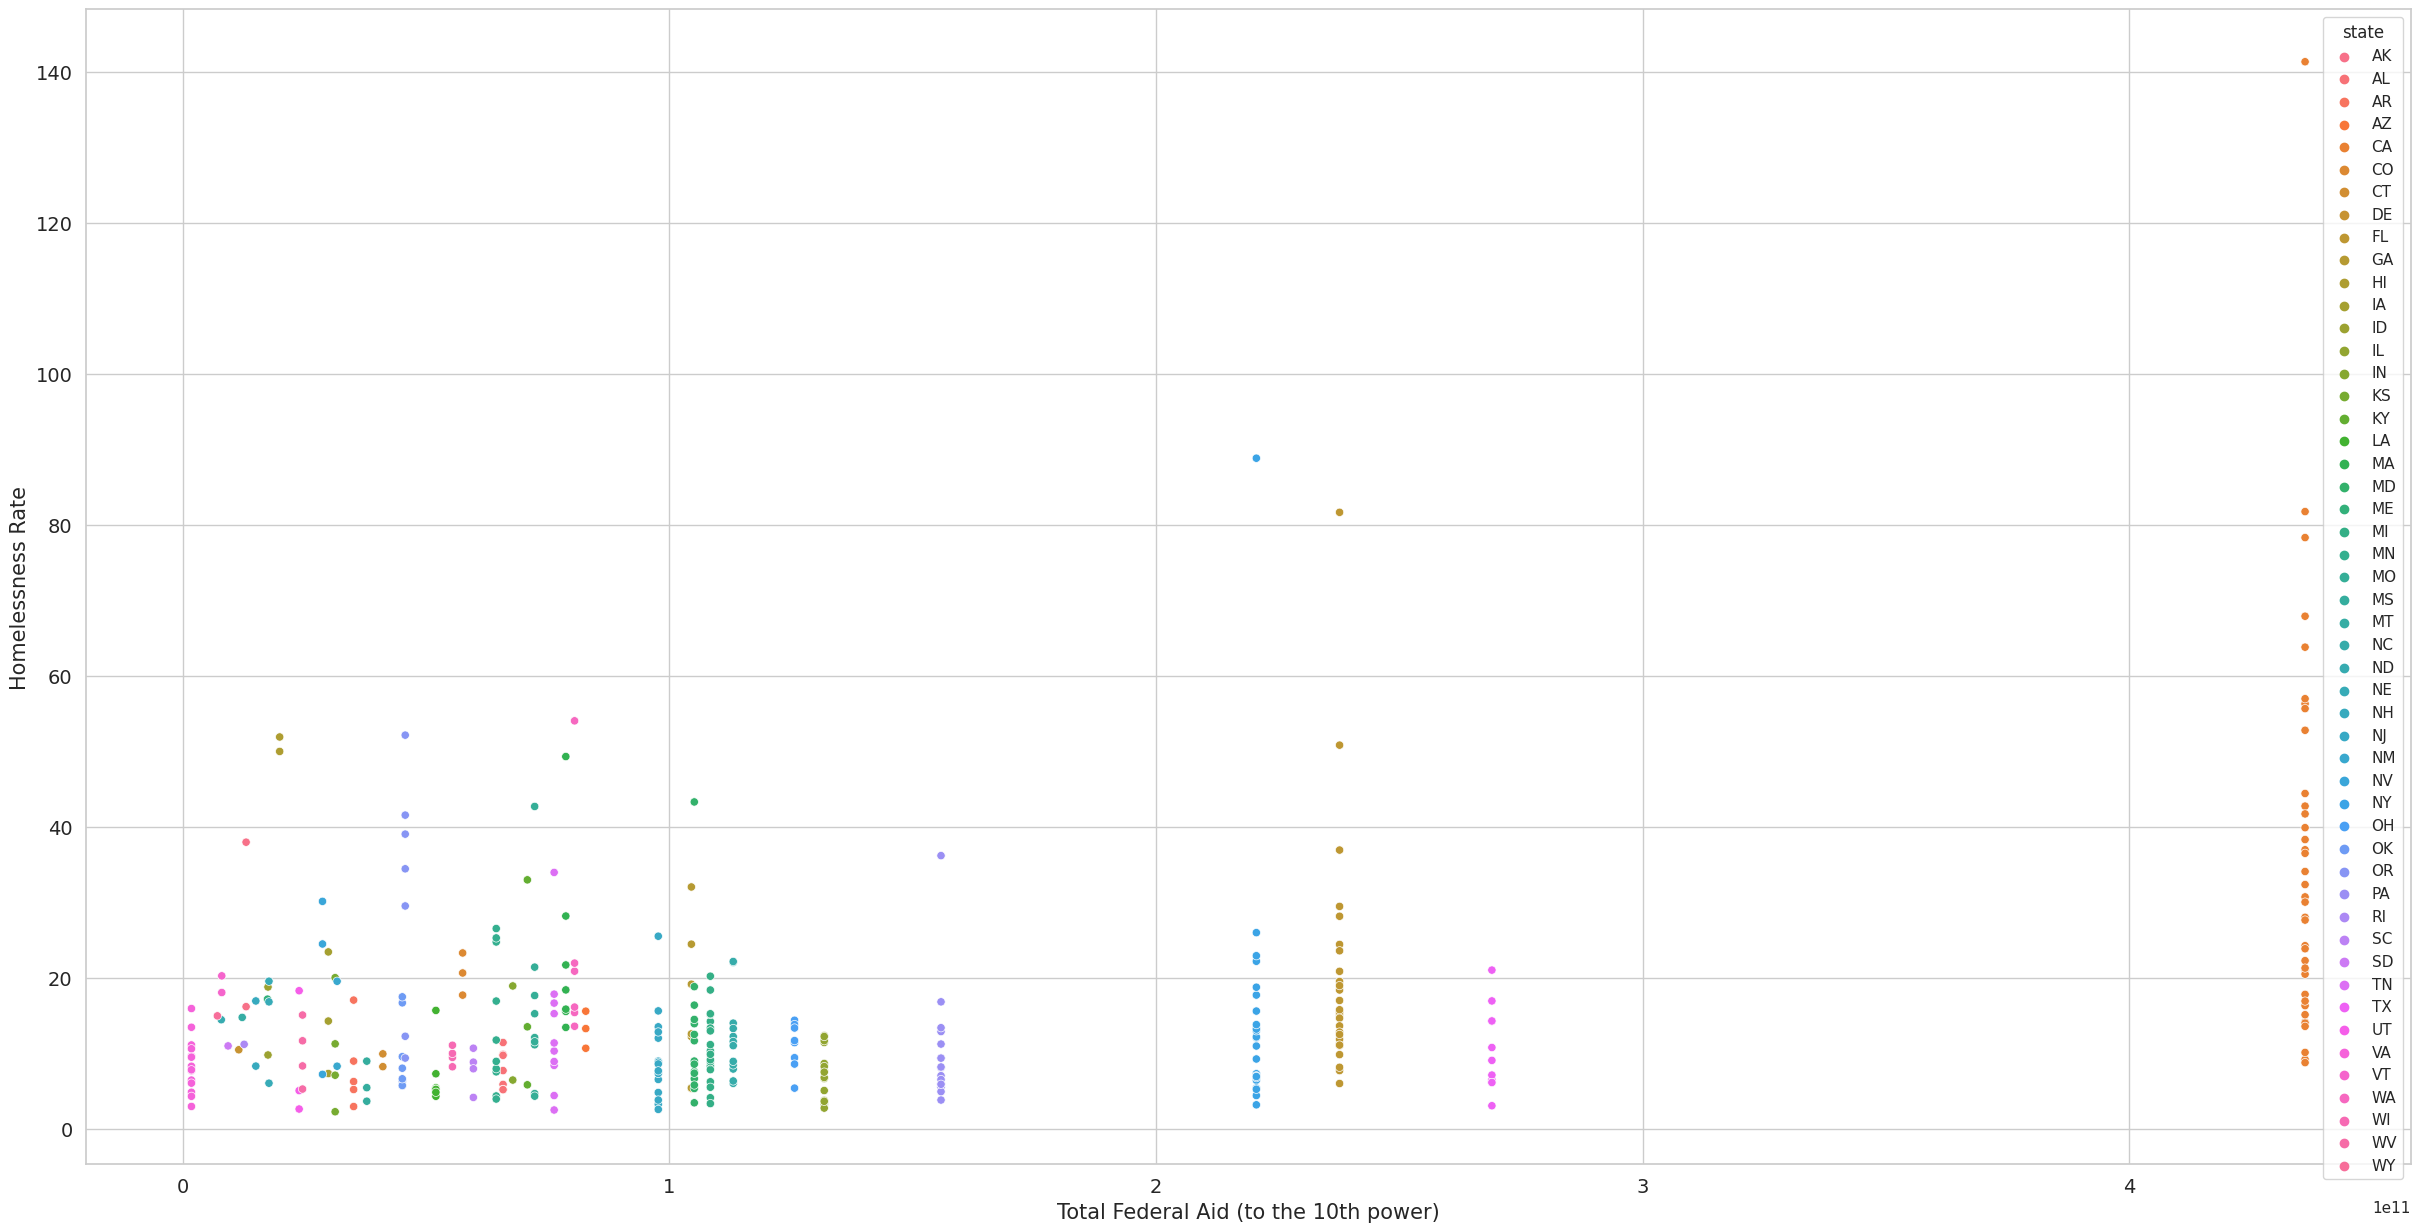

In [198]:
plt.figure(figsize=(30,15))
sns.scatterplot(data = df, x = 'total_federal_funding', y = 'rate_homeless', hue = 'state')

# Add axis labels
plt.xlabel('Total Federal Aid (to the 10th power)', fontsize=15)
plt.ylabel('Homelessness Rate', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

While a bit hard to read due to the large legend, this graph does show us that with more federal aid, there tends to be a correlation to a higher rate of homelessness. This tells us that the amount of federal aid that a state recieves is a good predictor of homelessness rate! 

## Conclusion

After analyzing the data, I can say that it is possible to predict homelessness rate of a CoC based on housing and economic factors. We were able to fit models that gave us R-squred values in the 0.5-0.6 range which means that the data was relatively well fit. I noticed that predictors relating to things like the number of vacant rentals, the percentage of people who spent a large amount of their income on housing, the number of people renting, and our additional step which looked at the amount of federal aid the government gave to each state. 